# Obligatorio - Machine Learning

### Universidad ORT

#### Alumnos : Felipe Bastarrica (158687), Aldo Gioda (XXXXXX), Esteban Maestro (XXXXXX)

## Library Installation

In [5]:
!pip install wandb
!pip install gradio

  Using cached wandb-0.15.4-py3-none-any.whl (2.1 MB)
  Using cached setproctitle-1.3.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached pathtools-0.1.2.tar.gz (11 kB)
  Using cached sentry_sdk-1.25.1-py2.py3-none-any.whl (206 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8785 sha256=0ff3a3ff1381e81c7274c42ff22a68558910b2ce8b14984c04e4adc5dcaba5be
  Stored in directory: /home/azureuser/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


#### Detele images from folders

In [1]:
# Clean folders

!rm images/train/1/*
!rm images/validation/1/*
!rm images/train/0/*
!rm images/validation/0/*

# Create folders
!mkdir images
!mkdir images/train
!mkdir images/validation

!mkdir images/train/0/
!mkdir images/validation/0/

!mkdir images/train/1/
!mkdir images/validation/1/


mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘images/train’: File exists
mkdir: cannot create directory ‘images/validation’: File exists
mkdir: cannot create directory ‘images/train/0/’: File exists
mkdir: cannot create directory ‘images/validation/0/’: File exists
mkdir: cannot create directory ‘images/train/1/’: File exists
mkdir: cannot create directory ‘images/validation/1/’: File exists


### Blob Connection and log parser

In [2]:
import pandas as pd
import json
import numpy as np


from io import StringIO
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

# Connection to Container
connection_string = "DefaultEndpointsProtocol=https;AccountName=cs210032001db9f06eb;AccountKey=Q7i41vK6zB2p/aKXulAdSROpoIou5uYj+EulJri7p9VI9VH4Us+Rlj+9fo5GC78TxSlPNQEWaDVY+AStDBpAfA==;EndpointSuffix=core.windows.net"
container_name = "container-ml"
blob_name = "properties_gallito.jl"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

blob_client = container_client.get_blob_client(blob_name)
csv_data = blob_client.download_blob().content_as_text()

# Replace commas for correct dataframe formation
csv_data2 = csv_data.replace(".jpg\",",".jpg\";").replace(", \"status\":","; \"status\":").replace(", {\"url\":", "; {\"url\":")

data = StringIO(csv_data2)
df = pd.read_csv(data, header=None, on_bad_lines='skip')

print(csv_data2)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Example of parsed images
df[7][0]

In [ ]:
# Dataframe from properties file
df.head()

### List of blobs 

In [3]:
# Function creates array of all blobs from container that contain .jpg in their name
def list_blobs_flat(blob_service_client: BlobServiceClient, container_name):
    container_client = blob_service_client.get_container_client(container=container_name)
    array = []
    blob_list = container_client.list_blobs()

    for blob in blob_list:
        if (".jpg" in blob.name):
            array.append(blob.name)
    return array

url_imagenes = list_blobs_flat(blob_service_client,"container-ml")

# Obtain labels from names
def get_labels(array_of_names):
    array = []

    for path in array_of_names:
        array.append(path.split("_")[2])
    return array

array_labels =  get_labels(url_imagenes)


#### Plot distribution of classes

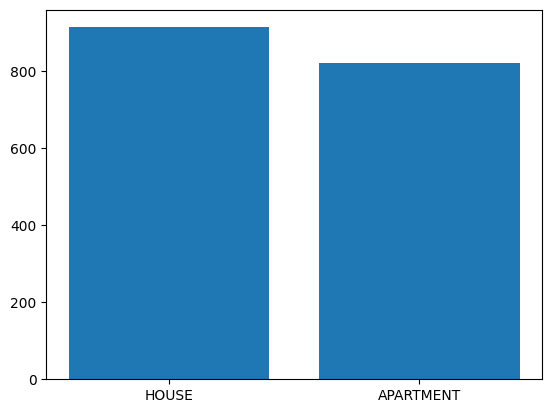

In [4]:
import matplotlib.pyplot as plt

count_classes = {"HOUSE":0, "APARTMENT":0}
for object in array_labels:
    count_classes[object] = count_classes[object] + 1 

classes = list(count_classes.keys())
values = list(count_classes.values())

plt.bar(range(len(count_classes)), values, tick_label=classes)
plt.show()

### Save images in Notebook folders

In [5]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import io
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from io import StringIO
import random

incr = 0
train_tabular_data = []
validation_tabular_data = []

for blobName in url_imagenes:
    incr += 1
    try:
        blob_service_client = BlobServiceClient.from_connection_string(conn_str=connection_string)
        blob_name = blobName
        blob_client = blob_service_client.get_blob_client(container_name, blob_name)

        stream = io.BytesIO()
        download_stream = blob_client.download_blob()

        stream.write(download_stream.readall())

        stream.seek(0)
        image = Image.open(stream)

        # Get information from URL
        id = (blobName.split("_")[0]).split("/")[1]
        tipo = blobName.split("_")[2]

        # Change traget to 0 and 1
        if (tipo == "HOUSE"):
            tipo = "0"
        else:
            tipo = "1"

        rooms = blobName.split("_")[3].split(".")[0]
        meters = blobName.split("_")[4].split("mts")[0]

        # Special case of "has" instead of mts
        if "has." in meters:
            meters = str(int(meters.split("has.")[0])*10000)

        # Sort partitions 80-20
        if random.uniform(0, 1) > 0.2:
            image.save("images/train/"+tipo+"/"+id+"_"+str(incr)+".jpg")
            train_tabular_data.append((rooms,meters,tipo))
        else:
            image.save("images/validation/"+tipo+"/"+id+"_"+str(incr)+".jpg")
            validation_tabular_data.append((rooms,meters,tipo))

    except Exception as ex:
        print('Exception:')



#### Save tabular data into CSVs

In [6]:
import csv 

train_tabular_data = np.array(train_tabular_data)
validation_tabular_data = np.array(validation_tabular_data)
headers = ["Cuartos","Meters","target"]

def write_csv(CSV_name, array, headers_csv):
    with open(CSV_name, 'w', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(headers_csv)
        for data in array:
            writer.writerow(data)
    
write_csv('csv_train.csv', train_tabular_data, headers)    
write_csv('csv_validation.csv', validation_tabular_data, headers)

#### Definitions

In [7]:
# Definitions
batch_size = 32
img_height = 180
img_width = 180
num_channels = 3
epochs = 30
steps_per_epoch = 30
validation_steps = 10
num_tabular_features = 2
class_names = ["HOUSE","APARTMENT"]
class_names_binary = ["0","1"]


### Plot images

0


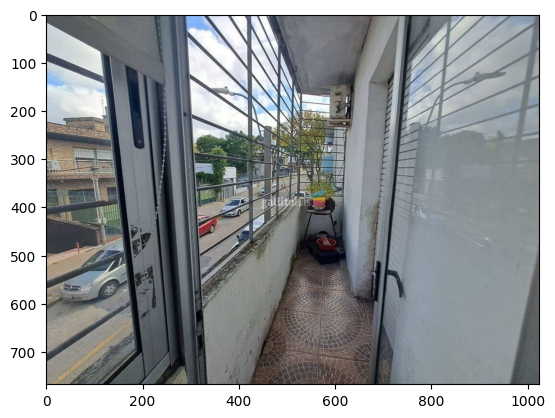

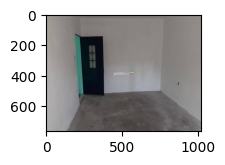

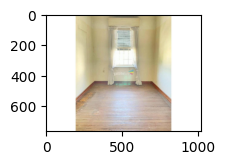

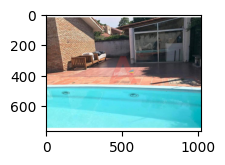

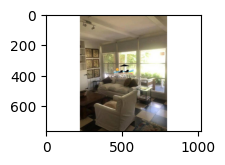

<Figure size 200x200 with 0 Axes>

1


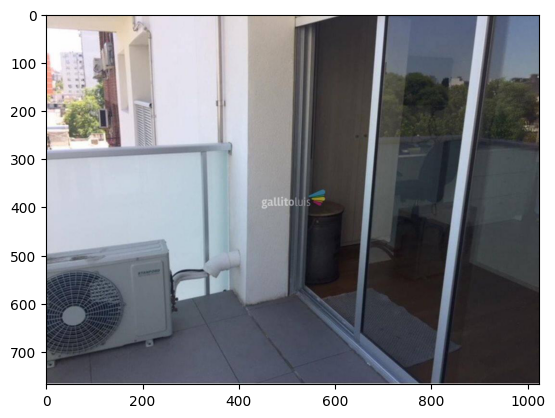

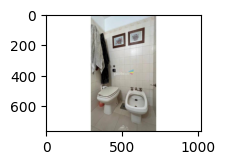

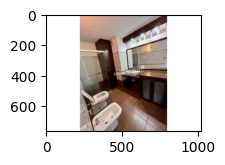

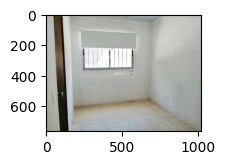

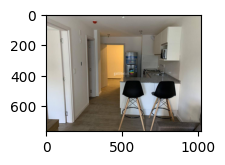

<Figure size 200x200 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import glob, random
from tensorflow.keras.utils import load_img

for class_type in class_names_binary:
    print(class_type)
    i = 0
    for i in range(5):
        images = glob.glob("images/train/"+str(class_type)+"/*.jpg")
        random_image = random.choice(images)

        # load the image
        img = load_img(random_image)

        plt.imshow(img)
        plt.figure(figsize=(2,2)) 
        i += 1
    plt.show()

### Dataset Generation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05,
        vertical_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'images/train',
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'images/validation',
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical')

2023-06-17 18:19:17.481077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 18:19:18.296560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 1362 images belonging to 2 classes.
Found 372 images belonging to 2 classes.


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the CSV file
data_train = pd.read_csv('csv_train.csv')
data_validation = pd.read_csv('csv_validation.csv')

data_train['Cuartos'] = data_train['Cuartos'].str.replace('D','')
data_train['Cuartos'] = data_train['Cuartos'].str.replace('+','')

data_validation['Cuartos'] = data_validation['Cuartos'].str.replace('D','')
data_validation['Cuartos'] = data_validation['Cuartos'].str.replace('+','')

# Split into features and target
X_train = data_train.drop('target', axis=1).astype(float).to_numpy()
y_train = data_train.iloc[:,-1].astype(float).to_numpy().reshape(-1, 1)
X_test = data_validation.drop('target', axis=1).astype(float).to_numpy()
y_test = data_validation.iloc[:,-1].astype(float).to_numpy().reshape(-1, 1)

In [10]:
# Concatenate batches of images
train_generator_concatenated=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
validation_generator_concatenated=np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])

In [11]:
# Transform targets to categorical objects
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

### Model Definition

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

image_input = Input(shape=(img_height, img_width, num_channels))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(pool2)
image_features = Dense(128, activation='relu')(flatten)

# Tabular Data Processing Branch
tabular_input = Input(shape=(num_tabular_features,))
tabular_features = Dense(64, activation='relu')(tabular_input)

# Fusion Layer
concatenated = Concatenate()([image_features, tabular_features])
#concatenated = concatenate([image_features, tabular_features])
fusion_layer = Dense(64, activation='relu')(concatenated)
#output = Dense(1, activation='sigmoid')(fusion_layer)
output = Dense(2, activation='softmax')(fusion_layer)
# Create the model
model = Model(inputs=[image_input, tabular_input], outputs=output)

model.summary()

2023-06-17 18:21:04.727486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 178, 178, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 89, 89, 32)   0           ['conv2d[0][0]']                 
                                                                                              

### Model compilation

In [13]:
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Execution of model

history = model.fit(x=[train_generator_concatenated, X_train], y=y_train, 
                        steps_per_epoch=steps_per_epoch,
                        epochs=10, 
                        validation_data=([validation_generator_concatenated, X_test], y_test), 
                        validation_steps = validation_steps)

Epoch 1/10
30/30 [==============================] - 21s 637ms/step - loss: 3.9364 - accuracy: 0.6461 - val_loss: 0.8139 - val_accuracy: 0.7419
Epoch 2/10
30/30 [==============================] - 19s 620ms/step - loss: 0.5671 - accuracy: 0.7416 - val_loss: 0.4852 - val_accuracy: 0.7500
Epoch 3/10
30/30 [==============================] - 18s 616ms/step - loss: 0.4749 - accuracy: 0.7665 - val_loss: 0.4751 - val_accuracy: 0.7392
Epoch 4/10
30/30 [==============================] - 18s 614ms/step - loss: 0.4934 - accuracy: 0.7548 - val_loss: 0.4609 - val_accuracy: 0.7715
Epoch 5/10
30/30 [==============================] - 19s 627ms/step - loss: 0.4327 - accuracy: 0.7900 - val_loss: 0.4649 - val_accuracy: 0.7661
Epoch 6/10
30/30 [==============================] - 19s 633ms/step - loss: 0.3928 - accuracy: 0.8216 - val_l

## WANDB

In [74]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import wandb
from wandb.keras import WandbCallback

# Account Key
wandb.login(key="bb15b17a6eb09e20bb877cebbceb375ade025b37")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [76]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

# Launch 2 experiments, trying different dropout rates
for run in range(2):
    
    # Start a run, tracking hyperparameters
    wandb.init(
        project="ml-en-produccion",
        config={
        
            #"activation_1": "relu",
            "img_height": 180,
            "img_width": 180,
            "dropout": random.uniform(0.01, 0.80),
            "optimizer": "adam",
            "loss": "categorical_crossentropy",
            "metric": "accuracy",
            "epoch": 10,
            "batch_size": 32,
            "steps_per_epoch":30,
            "validation_steps":10
        },
    )
    config = wandb.config
    

    # Define tu modelo
    
    image_input = Input(shape=(img_height, img_width, num_channels))
    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten = Flatten()(pool2)
    image_features = Dense(128, activation='relu')(flatten)

    # Tabular Data Processing Branch
    tabular_input = Input(shape=(num_tabular_features,))
    tabular_features = Dense(64, activation='relu')(tabular_input)

    # Fusion Layer
    concatenated = Concatenate()([image_features, tabular_features])
    #concatenated = concatenate([image_features, tabular_features])
    fusion_layer = Dense(64, activation='relu')(concatenated)
    #output = Dense(1, activation='sigmoid')(fusion_layer)
    output = Dense(2, activation='softmax')(fusion_layer)
    # Create the model
    model = Model(inputs=[image_input, tabular_input], outputs=output)
    # Compila y entrena el modelo
    model.compile(optimizer=config.optimizer, loss=config.loss,  metrics=[config.metric])

    # Early toppong
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


    # Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints
    wandb_callbacks = [
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath="my_model_{epoch:02d}"),
    ]
    history = model.fit(x=[train_generator_concatenated, X_train], y=y_train, 
                        steps_per_epoch=config.steps_per_epoch,
                        epochs=config.epoch, 
                        validation_data=([validation_generator_concatenated, X_test], y_test), 
                        validation_steps = config.validation_steps,
                        callbacks=[wandb_callbacks,earlystopping_callback])

    
    wandb.finish()

Epoch 1/10
30/30 [==============================] - 27s 882ms/step - loss: 1.1842 - accuracy: 0.7137 - val_loss: 0.5362 - val_accuracy: 0.7446
Epoch 2/10
30/30 [==============================] - 25s 854ms/step - loss: 0.6660 - accuracy: 0.7159 - val_loss: 0.5352 - val_accuracy: 0.7151
Epoch 3/10
30/30 [==============================] - 26s 869ms/step - loss: 0.4458 - accuracy: 0.7878 - val_loss: 0.4866 - val_accuracy: 0.7554
Epoch 4/10
30/30 [==============================] - 27s 901ms/step - loss: 0.4255 - accuracy: 0.8040 - val_loss: 0.4936 - val_accuracy: 0.7366
Epoch 5/10
30/30 [==============================] - 26s 874ms/step - loss: 0.3012 - accuracy: 0.8781 - val_loss: 0.6634 - val_accuracy: 0.7366
Epoch 6/10
30/30 [==============================] - 27s 898ms/step - loss: 0.2288 - accuracy: 0.9031 - val_loss: 0.6955 - val_accuracy: 0.7016
Epoch 7/10
30/30 [==============================] - 27s 904ms/step - loss: 0.1192 - accuracy: 0.9596 - val_loss: 1.0029 - val_accuracy: 0.7258

INFO:tensorflow:Assets written to: my_model_01/assets
wandb: Adding directory to artifact (./my_model_01)... Done. 4.4s
INFO:tensorflow:Assets written to: my_model_02/assets
wandb: Adding directory to artifact (./my_model_02)... Done. 3.9s
INFO:tensorflow:Assets written to: my_model_03/assets
wandb: Adding directory to artifact (./my_model_03)... Done. 4.2s
INFO:tensorflow:Assets written to: my_model_04/assets
wandb: Adding directory to artifact (./my_model_04)... Done. 4.8s
INFO:tensorflow:Assets written to: my_model_05/assets
wandb: Adding directory to artifact (./my_model_05)... Done. 4.1s
INFO:tensorflow:Assets written to: my_model_06/assets
wandb: Adding directory to artifact (./my_model_06)... Done. 4.4s
INFO:tensorflow:Assets written to: my_model_07/assets
wandb: Adding directory to artifact (./my_model_07)... Done. 4.6s
INFO:tensorflow:Assets written to: my_model_08/assets
wandb: Adding directory to artifact (./my_model_08)... Done. 3.7s
INFO:tensorflow:Assets written to: my_mo

epoch/accuracy,▁▁▃▃▅▆▇███
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▁▁▁
epoch/val_accuracy,▇▃█▆▆▁▄▂▃▂
epoch/val_loss,▁▁▁▁▂▃▅▇▆█
epoch/accuracy,0.99927
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.0133
epoch/val_accuracy,0.71237


Epoch 1/10
30/30 [==============================] - 29s 932ms/step - loss: 1.2597 - accuracy: 0.7372 - val_loss: 0.4709 - val_accuracy: 0.7715
Epoch 2/10
30/30 [==============================] - 28s 929ms/step - loss: 0.4841 - accuracy: 0.7761 - val_loss: 0.5727 - val_accuracy: 0.7366
Epoch 3/10
30/30 [==============================] - 28s 957ms/step - loss: 0.4951 - accuracy: 0.7863 - val_loss: 0.6769 - val_accuracy: 0.6694
Epoch 4/10
30/30 [==============================] - 27s 924ms/step - loss: 0.5443 - accuracy: 0.7636 - val_loss: 0.6962 - val_accuracy: 0.6694
Epoch 5/10
30/30 [==============================] - 26s 884ms/step - loss: 0.4157 - accuracy: 0.8209 - val_loss: 0.5607 - val_accuracy: 0.7204
Epoch 6/10
30/30 [==============================] - 26s 867ms/step - loss: 0.3415 - accuracy: 0.8612 - val_loss: 0.7586 - val_accuracy: 0.7285
Epoch 7/10
30/30 [==============================] - 26s 866ms/step - loss: 0.1989 - accuracy: 0.9229 - val_loss: 0.9043 - val_accuracy: 0.7258

INFO:tensorflow:Assets written to: my_model_01/assets
wandb: Adding directory to artifact (./my_model_01)... Done. 5.0s
INFO:tensorflow:Assets written to: my_model_02/assets
wandb: Adding directory to artifact (./my_model_02)... Done. 4.7s
INFO:tensorflow:Assets written to: my_model_03/assets
wandb: Adding directory to artifact (./my_model_03)... Done. 6.2s
INFO:tensorflow:Assets written to: my_model_04/assets
wandb: Adding directory to artifact (./my_model_04)... Done. 4.6s
INFO:tensorflow:Assets written to: my_model_05/assets
wandb: Adding directory to artifact (./my_model_05)... Done. 4.6s
INFO:tensorflow:Assets written to: my_model_06/assets
wandb: Adding directory to artifact (./my_model_06)... Done. 4.1s
INFO:tensorflow:Assets written to: my_model_07/assets
wandb: Adding directory to artifact (./my_model_07)... Done. 4.0s
INFO:tensorflow:Assets written to: my_model_08/assets
wandb: Adding directory to artifact (./my_model_08)... Done. 5.3s
INFO:tensorflow:Assets written to: my_mo

epoch/accuracy,▁▂▂▂▃▅▆▇▇█
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▄▃▃▂▁▁▁
epoch/val_accuracy,█▆▁▁▅▅▅▃▅▅
epoch/val_loss,▁▂▂▂▂▃▄█▇▆
epoch/accuracy,0.98311
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.04637
epoch/val_accuracy,0.72581


### Plot metrics

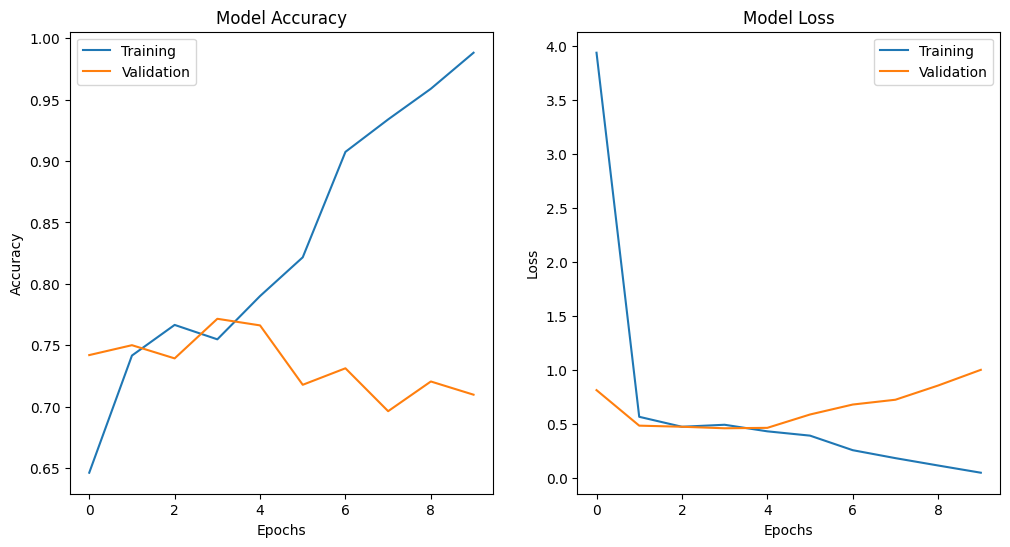

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training')
    plt.plot(history_df['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training')
    plt.plot(history_df['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('training_validation_plots.png')
    plt.show()

# Call the plotting function to display the graphs
plot_history(history)

# Save the trained model
model.save('conv_categorical.h5')

In [54]:
# For testing, convert image to tensor and add dimension in first position
def input_conversion (image, tabular):
    tensor_img = tf.convert_to_tensor(image)
    tensor_tab = tf.convert_to_tensor(tabular)
    tensor_img = tf.expand_dims(tensor_img, 0)
    tensor_tab = tf.expand_dims(tensor_tab, 0)
    return tensor_img,tensor_tab

tensor_img, tensor_tab = input_conversion (validation_generator_concatenated[0], X_test[0])


In [55]:
# Make a simple prediction
prediction = model.predict([tensor_img, tensor_tab])
print (prediction)

1/1 [==============================] - 0s 99ms/step
[[0.03841284 0.9615872 ]]


### Gradio

In [68]:
import numpy as np

# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model

# load model
model = load_model('conv_categorical.h5')

def classify_image(image, rooms, meters):
    image = np.expand_dims(image, axis=0)
    tabular = np.expand_dims([rooms,meters], axis=0).astype(float)
    print(image.shape)
    print(tabular.shape)
    prediction = model.predict([image,tabular])

    # Obtiene las etiquetas de las clases
    class_labels = ['HOUSE','APARTMENT']
    # Devuelve un diccionario con las etiquetas de las clases y sus probabilidades correspondientes
    return {class_labels[i]: float(prediction[0][i]) for i in range(2)}
    #return prediction[0]

In [71]:
import gradio as gr

iface = gr.Interface(
    fn=classify_image,  # la función que hace la clasificación
    inputs=[gr.inputs.Image(shape=(img_height, img_width)), gr.inputs.Slider(0,5,label="Dormitorios", step=1), gr.inputs.Slider(0,5000,label="M2")],#,"text", "text"],#, gr.inputs.Slider(0,5,label="Dormitorios"), gr.inputs.Slider(0,5000,label="M2")],  # el tipo de entrada que espera tu modelo
    outputs=gr.outputs.Label(num_top_classes=1),  # el tipo de salida que produce tu modelo
)
iface.launch(share=True, debug=True)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/gradio/inputs.py:89: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/gradio/inputs.py:93: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported i

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1122df478946832c0a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


(1, 180, 180, 3)
(1, 2)
1/1 [==============================] - 0s 44ms/step
(1, 180, 180, 3)
(1, 2)
1/1 [==============================] - 0s 49ms/step
(1, 180, 180, 3)
(1, 2)
1/1 [==============================] - 0s 254ms/step
(1, 180, 180, 3)
(1, 2)
1/1 [==============================] - 0s 43ms/step
(1, 180, 180, 3)
(1, 2)
1/1 [==============================] - 0s 49ms/step
(1, 180, 180, 3)
(1, 2)
1/1 [==============================] - 0s 47ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1122df478946832c0a.gradio.live
